In [2]:
import os
os.getcwd()

'/home/jupyter/grade_A'

Using device: cuda

--- Fraction of labelled data: 1.0% ---
Epoch 1, Training Loss: 3.6939
Epoch 2, Training Loss: 2.4852
Epoch 3, Training Loss: 1.6936
Epoch 4, Training Loss: 1.4143
Epoch 5, Training Loss: 1.1283
Epoch 1, Training Loss: 1.3589
Epoch 2, Training Loss: 0.5775
Epoch 3, Training Loss: 0.2146
Fraction: 0.01, Test Accuracy: 8.9670%

--- Fraction of labelled data: 10.0% ---
Epoch 1, Training Loss: 3.6159
Epoch 2, Training Loss: 2.0466
Epoch 3, Training Loss: 1.1863
Epoch 4, Training Loss: 0.6713
Epoch 5, Training Loss: 0.3848
Epoch 1, Training Loss: 1.0405
Epoch 2, Training Loss: 0.3459
Epoch 3, Training Loss: 0.1156
Fraction: 0.1, Test Accuracy: 68.3565%

--- Fraction of labelled data: 50.0% ---
Epoch 1, Training Loss: 2.4318
Epoch 2, Training Loss: 0.7625
Epoch 3, Training Loss: 0.3068
Epoch 4, Training Loss: 0.1345
Epoch 5, Training Loss: 0.0743
Epoch 1, Training Loss: 0.2552
Epoch 2, Training Loss: 0.0582
Epoch 3, Training Loss: 0.0249
Fraction: 0.5, Test Accuracy: 86.1

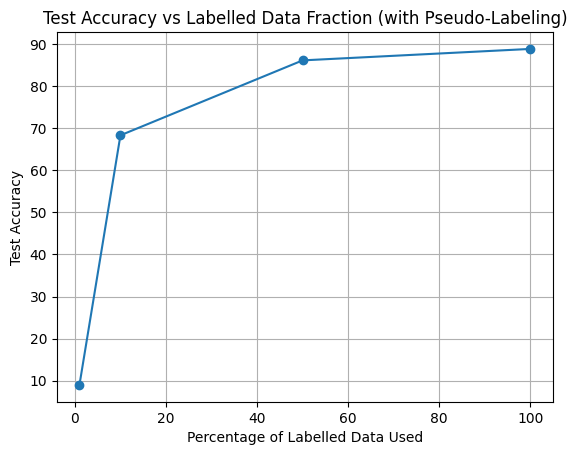

In [8]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Custom Dataset wrapper to apply a specific transform ---
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
class PseudoLabelledDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx].item()  # .item() ensures label is an int

    def __len__(self):
        return len(self.images)

def generate_pseudo_labels(model, unlabelled_loader):
    model.eval()
    pseudo_images = []
    pseudo_labels = []
    with torch.no_grad():
        for imgs, _ in unlabelled_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            pseudo_images.append(imgs.cpu())
            pseudo_labels.append(preds.cpu())
    pseudo_images = torch.cat(pseudo_images)
    pseudo_labels = torch.cat(pseudo_labels)
    return PseudoLabelledDataset(pseudo_images, pseudo_labels)

# --- Subsample dataset by fraction, stratified by class ---
def subsample_dataset(dataset, fraction):
    targets = np.array([y for _, y in dataset])
    classes = np.unique(targets)
    indices = []
    for c in classes:
        class_indices = np.where(targets == c)[0]
        n_samples = max(1, int(len(class_indices) * fraction))
        indices.extend(np.random.choice(class_indices, n_samples, replace=False))
    np.random.shuffle(indices)
    return Subset(dataset, indices)

# --- Training loop ---
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}")

# --- Evaluation ---
def test_model(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

# --- Load Oxford-IIIT Pet Dataset for multi-class classification ---
base_train_val_dataset = OxfordIIITPet(root='./dataset', split='trainval', target_types='category', download=True)
test_dataset_raw = OxfordIIITPet(root='./dataset', split='test', target_types='category', download=True)

# --- Split train/val ---
num_train_val_samples = len(base_train_val_dataset)
val_fraction = 0.2
num_val_samples = int(val_fraction * num_train_val_samples)
num_train_samples_for_split = num_train_val_samples - num_val_samples
train_subset_raw, val_subset_raw = torch.utils.data.random_split(base_train_val_dataset, [num_train_samples_for_split, num_val_samples])

# --- Apply transforms ---
train_subset = TransformedDataset(train_subset_raw, transform=transform)
val_subset = TransformedDataset(val_subset_raw, transform=transform)
test_dataset = TransformedDataset(test_dataset_raw, transform=transform)

val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

num_classes = 37

# --- Fractions to test ---
fractions = [0.01, 0.1, 0.5, 1.0]
results = []

for frac in fractions:
    print(f"\n--- Fraction of labelled data: {frac*100:.1f}% ---")
    # 1. Subsample labelled data
    labelled_subset = subsample_dataset(train_subset, frac)
    labelled_loader = DataLoader(labelled_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

    # 2. Unlabelled data (the rest)
    all_indices = set(range(len(train_subset)))
    labelled_indices = set(labelled_subset.indices)
    unlabelled_indices = list(all_indices - labelled_indices)
    unlabelled_subset = Subset(train_subset, unlabelled_indices)
    unlabelled_loader = DataLoader(unlabelled_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # 3. Train on labelled data
    model = resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    train_model(model, labelled_loader, optimizer, criterion, num_epochs=5)

    if len(unlabelled_subset) > 0:
        pseudo_labelled_dataset = generate_pseudo_labels(model, unlabelled_loader)
        # 5. Combine and retrain
        combined_dataset = ConcatDataset([labelled_subset, pseudo_labelled_dataset])
        combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
        train_model(model, combined_loader, optimizer, criterion, num_epochs=3)

    # 6. Evaluate
    acc = test_model(model, test_loader)
    results.append((frac, acc))
    print(f"Fraction: {frac}, Test Accuracy: {acc:.4f}%")

# --- Plot results ---
fractions, accuracies = zip(*results)
plt.plot([f*100 for f in fractions], accuracies, marker='o')
plt.xlabel('Percentage of Labelled Data Used')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Labelled Data Fraction (with Pseudo-Labeling)')
plt.grid(True)
plt.show()

In [9]:
pip install transformers datasets timm torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 54.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 156.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 167.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch.nn as nn
import torch.optim as optim

# 1. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load ViT feature extractor (for normalization)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# 3. Define transform for ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# 4. Load Oxford-IIIT Pet dataset (multi-class: 37 breeds)
train_dataset = OxfordIIITPet(root='./dataset', split='trainval', target_types='category', transform=transform, download=True)
test_dataset = OxfordIIITPet(root='./dataset', split='test', target_types='category', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# 5. Load pre-trained ViT model for classification
num_labels = 37
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_labels
)
model = model.to(device)

# 6. Training and evaluation functions
def train_vit(model, loader, optimizer, criterion, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=imgs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(loader):.4f}")

def test_vit(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(pixel_values=imgs)
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# 7. Set up optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# 8. Train and evaluate
print("Starting ViT fine-tuning...")
train_vit(model, train_loader, optimizer, criterion, num_epochs=3)
acc = test_vit(model, test_loader)
print(f"ViT Test Accuracy: {acc:.2f}%")

Using device: cuda


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting ViT fine-tuning...
Epoch 1, Loss: 2.8873
Epoch 2, Loss: 1.6387
Epoch 3, Loss: 0.8810
ViT Test Accuracy: 92.64%

--- ViT vs ResNet Summary ---
ViT Advantages: Captures global context, strong with large data, state-of-the-art potential.
ViT Disadvantages: Needs more data, more compute, sensitive to hyperparameters.
ResNet Advantages: Robust on small/medium data, easy to fine-tune, less compute.
ResNet Disadvantages: May miss global context, slightly lower ceiling on huge data.
ViT fine-tuning is straightforward with Hugging Face Transformers, but requires more VRAM and compute than ResNet.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import OxfordIIITPet
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import DataLoader
import math

# 1. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. LoRA module for Linear layers
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, r=8, alpha=16, dropout=0.1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.r = r
        self.alpha = alpha
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        if r > 0:
            self.lora_A = nn.Parameter(torch.zeros((r, in_features)))
            self.lora_B = nn.Parameter(torch.zeros((out_features, r)))
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)
            self.scaling = alpha / r
        else:
            self.lora_A = None
            self.lora_B = None
            self.scaling = 1.0

    def forward(self, x):
        result = self.linear(x)
        if self.r > 0:
            # x: (batch, in_features)
            lora_out = self.dropout(x) @ self.lora_A.t()  # (batch, r)
            lora_out = lora_out @ self.lora_B.t()         # (batch, out_features)
            result = result + self.scaling * lora_out
        return result

# 3. Data transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Load Oxford-IIIT Pet dataset (binary: cat vs dog)
train_dataset = OxfordIIITPet(root='./dataset', split='trainval', target_types='binary-category', transform=transform, download=True)
test_dataset = OxfordIIITPet(root='./dataset', split='test', target_types='binary-category', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# 5. Load ResNet18 and patch with LoRA in the final layer
model = resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False  # Freeze backbone

# Replace the final fully connected layer with LoRA-wrapped Linear
model.fc = LoRALinear(model.fc.in_features, 37, r=8, alpha=16, dropout=0.1)

# Only LoRA parameters are trainable
for name, param in model.named_parameters():
    if "lora" in name or "linear" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)

# 6. Optimizer and loss
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 7. Print trainable parameters
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {num_trainable} / {num_total} ({100*num_trainable/num_total:.2f}%)")

# 8. Training loop
def train(model, loader, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(loader):.4f}")

# 9. Evaluation
def test(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# 10. Train and evaluate
print("Starting ResNet18+LoRA fine-tuning...")
train(model, train_loader, optimizer, criterion, num_epochs=5)
acc = test(model, test_loader)
print(f"ResNet18+LoRA Test Accuracy: {acc:.2f}%")

Using device: cuda
Trainable params: 23373 / 11199885 (0.21%)
Starting ResNet18+LoRA fine-tuning...
Epoch 1, Loss: 0.3961
Epoch 2, Loss: 0.1007
Epoch 3, Loss: 0.0745
Epoch 4, Loss: 0.0598
Epoch 5, Loss: 0.0464
ResNet18+LoRA Test Accuracy: 98.39%


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import OxfordIIITPet
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

# 1. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Data transforms and loaders
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = OxfordIIITPet(root='./dataset', split='trainval', target_types='binary-category', transform=transform, download=True)
test_dataset = OxfordIIITPet(root='./dataset', split='test', target_types='binary-category', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# 3. Training and evaluation functions
def train_masked(model, loader, optimizer, criterion, weight_mask, bias_mask, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            # Apply mask to gradients
            with torch.no_grad():
                model.fc.weight.grad *= weight_mask
                model.fc.bias.grad *= bias_mask
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(loader):.4f}")

def test(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# 4. Try different mask fractions
mask_fractions = [0.01, 0.1, 0.5, 1.0]
results = []

for mask_fraction in mask_fractions:
    print(f"\n--- Masked fine-tuning with mask_fraction={mask_fraction} ---")
    # Model setup
    model = resnet18(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)

    # Masked fine-tuning setup
    fc_weight = model.fc.weight
    fc_bias = model.fc.bias

    # Create random masks for weights and bias
    weight_mask = torch.zeros_like(fc_weight, dtype=torch.bool)
    bias_mask = torch.zeros_like(fc_bias, dtype=torch.bool)
    num_weight_params = fc_weight.numel()
    num_bias_params = fc_bias.numel()
    weight_indices = np.random.choice(num_weight_params, int(mask_fraction * num_weight_params), replace=False)
    bias_indices = np.random.choice(num_bias_params, int(mask_fraction * num_bias_params), replace=False)
    weight_mask.view(-1)[weight_indices] = True
    bias_mask.view(-1)[bias_indices] = True

    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_masked(model, train_loader, optimizer, criterion, weight_mask, bias_mask, num_epochs=5)
    acc = test(model, test_loader)
    print(f"Masked fine-tuning Test Accuracy: {acc:.2f}%")
    results.append((mask_fraction, acc))

# 5. Baseline: full fine-tuning of fc layer (no mask)
print("\n--- Baseline: full fine-tuning (all fc params trainable) ---")
model = resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
# Create masks with all True (no masking)
weight_mask = torch.ones_like(model.fc.weight, dtype=torch.bool)
bias_mask = torch.ones_like(model.fc.bias, dtype=torch.bool)
train_masked(model, train_loader, optimizer, criterion, weight_mask, bias_mask, num_epochs=5)
acc = test(model, test_loader)
print(f"Baseline fine-tuning Test Accuracy: {acc:.2f}%")
results.append(("full", acc))

# 6. Print summary
print("\nSummary:")
for frac, acc in results:
    print(f"Mask fraction: {frac}, Test Accuracy: {acc:.2f}%")

Using device: cuda

--- Masked fine-tuning with mask_fraction=0.01 ---
Epoch 1, Loss: 0.7012
Epoch 2, Loss: 0.6471
Epoch 3, Loss: 0.6174
Epoch 4, Loss: 0.5909
Epoch 5, Loss: 0.5744
Masked fine-tuning Test Accuracy: 72.99%

--- Masked fine-tuning with mask_fraction=0.1 ---
Epoch 1, Loss: 0.4695
Epoch 2, Loss: 0.2919
Epoch 3, Loss: 0.2333
Epoch 4, Loss: 0.1975
Epoch 5, Loss: 0.1805
Masked fine-tuning Test Accuracy: 94.17%

--- Masked fine-tuning with mask_fraction=0.5 ---
Epoch 1, Loss: 0.2600
Epoch 2, Loss: 0.1213
Epoch 3, Loss: 0.0894
Epoch 4, Loss: 0.0818
Epoch 5, Loss: 0.0668
Masked fine-tuning Test Accuracy: 97.93%

--- Masked fine-tuning with mask_fraction=1.0 ---
Epoch 1, Loss: 0.2127
Epoch 2, Loss: 0.0843
Epoch 3, Loss: 0.0643
Epoch 4, Loss: 0.0611
Epoch 5, Loss: 0.0507
Masked fine-tuning Test Accuracy: 98.64%

--- Baseline: full fine-tuning (all fc params trainable) ---
Epoch 1, Loss: 0.1738
Epoch 2, Loss: 0.0865
Epoch 3, Loss: 0.0649
Epoch 4, Loss: 0.0545
Epoch 5, Loss: 0.0581
